<IPython.core.display.Javascript object>


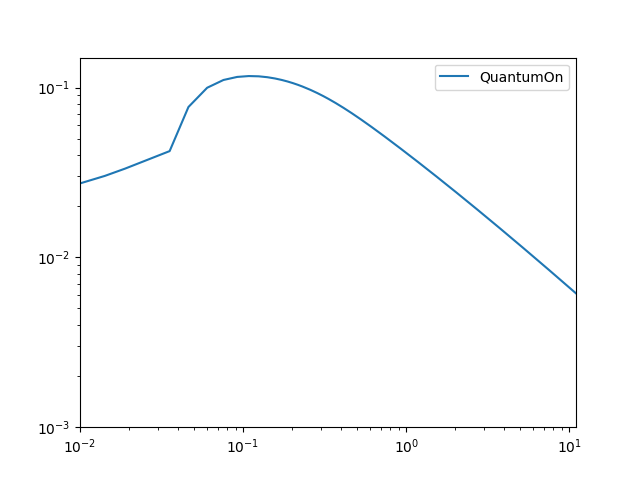

In [1]:
%matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import integrate

def ReadData(path):
    path = 'ExampleAlexGitHub/Li-Petrasso/'+ path
    data = open(path, "r")
    lines = []
    for line in data:
        lines.append(line)   
    X = []
    Y = []      
    for j in range(0,len(lines)):
        string = lines[j].split(',')
        X.append(float(string[0]))
        Y.append(-float(string[1]))
    return X, Y

## QuantumDegeneracy = 0, no quantum correction ,QuantumDegeneracy = 1 Yes
## OptionDebyeLength = 0 , Tottal, OptionDebyeLength = 1 , UseElectronsDebyeLength ,
## OptionDebyeLength = 2 , I use I E use E
def LP (QuantumDegeneracy, OptionDebyeLength,FieldDensity, FieldTem, FieldCharge, FieldMass, ProjE, ProjM, ProjC):

    class Particles(object):
        
        hbar = 1.054571e-27
        amu = 1.6726219e-24   # Unit: gram
        eMass = 9.10938356e-28 # Unit: gram
        Boltz = 1.38065e-16    #  cm2 g s2 K-1
        e = 4.80319685e-10     #statcoulomb
        eVToKelvin = 11604.5
        MeVToErg = 1.6021773e-6  # MeV to cgs unit energy centimetre–gram–second
    
        def __init__(self, PN, Mass, Charge, Tempe, Density):
            if PN > 0 :
                self.Mass = Mass*self.amu
                self.Charge = Charge*self.e
                self.NumDensity = Density/self.Mass
            else:
                self.Mass = self.eMass
                self.Charge = self.e
                self.NumDensity = Density/(Mass*self.amu)*Charge
                
            self.Tempe = Tempe*self.eVToKelvin
            self.Ratio = self.Tempe*(8*np.pi/(3*self.NumDensity))**(2/3)*\
                2*self.Mass*self.Boltz/(self.hbar*2*np.pi)**2
        
    ###################################################################
    ########  Quantum corrrection (Low T high rho regime )     ########
    ###################################################################    
        
            self.mukbt = -3/2*np.log(self.Ratio)+math.log(4/(3*np.sqrt(np.pi)))+\
            (0.25054*self.Ratio**(-1.858)+0.072*self.Ratio**(-1.858/2))/(1+0.25054*self.Ratio**(-0.868))
            
            FermiDirac1 = lambda t: t**(1/2)/(np.exp(t-self.mukbt)+1)
            FermiDirac2 = lambda t: t**(3/2)/(np.exp(t-self.mukbt)+1)
            FermiDirac1 = integrate.quad(FermiDirac1, 0, 400)[0] * np.sqrt(np.pi)/2
            FermiDirac2 = integrate.quad(FermiDirac2, 0, 400)[0]* np.sqrt(np.pi)/2*3/2
            
            self.EffectiveTempe = self.Tempe*(FermiDirac2/FermiDirac1)
            
            self.ThermalVelocity = np.sqrt(2*self.Boltz*self.Tempe/self.Mass)
            self.DebyeLength = np.sqrt(self.Boltz*self.EffectiveTempe/(4*np.pi*self.NumDensity*self.Charge**2))
            self.freq = np.sqrt(4*np.pi*self.NumDensity*self.Charge**2/self.Mass)
        
        def CoulombLog(self, ProjectileMass, ProjectileVelocity, ProjectileCharge, TotalDebyeLength, UseEDebyeLength):
            self.ReducedMass = ProjectileMass*self.Mass/(ProjectileMass+self.Mass)
            if QuantumDegeneracy == 1:
                self.RelativeVelocity = np.sqrt(ProjectileVelocity**2 + (8*self.Boltz*self.EffectiveTempe/(np.pi*self.Mass)))
            else:
                self.RelativeVelocity = np.sqrt(ProjectileVelocity**2 + (8*self.Boltz*self.Tempe/(np.pi*self.Mass)))
            #self.RelativeVelocity = ProjectileVelocity - self.ThermalVelocity
            self.Pperp = ProjectileCharge*self.Charge/(self.ReducedMass*self.RelativeVelocity**2)
            # the term Pmin corresponding to minimum impact factor(Max Momentum transfer)      
            self.Pmin = np.sqrt(self.Pperp**2+(self.hbar/(2*self.ReducedMass*self.RelativeVelocity))**2)
            if OptionDebyeLength == 0:
                return 0.5*math.log(1+(TotalDebyeLength/self.Pmin)**2)
            elif OptionDebyeLength == 1:
                return 0.5*math.log(1+(UseEDebyeLength/self.Pmin)**2)
            else:
                return 0.5*math.log(1+(self.DebyeLength/self.Pmin)**2)
            
        def Gxtf (self, ProjectileMass, ProjectileVelocity, TotalDebyeLength, CoulombLoginput):
            self.xtf = (ProjectileVelocity/self.ThermalVelocity)**2
            self.xtf_collective = 2*(ProjectileVelocity/self.ThermalVelocity)**2  ## Following the Erratum statement
            self.test = 86666
            self.muxtf = np.sqrt(np.pi)/2*math.erf(np.sqrt(self.xtf))-np.sqrt(self.xtf)*np.exp(-self.xtf)
            self.dudx = np.sqrt(self.xtf)*np.exp(-self.xtf)
            return self.muxtf - self.Mass/ProjectileMass*(self.dudx-(self.muxtf+self.dudx)/CoulombLoginput)
            
    #Condition Initialization      
    Ions = Particles(PN = 1, Mass=FieldMass,Charge=FieldCharge,Tempe=FieldTem,Density=FieldDensity)
    Electrons = Particles(PN = 0, Mass=FieldMass,Charge=FieldCharge,Tempe=FieldTem,Density=FieldDensity)
    
    if QuantumDegeneracy == 1:
        TotalDebyeLength = np.sqrt(Ions.Boltz*Ions.EffectiveTempe/(4*np.pi*(Ions.NumDensity*Ions.Charge**2+\
                                                               Electrons.NumDensity*Electrons.Charge**2)) )  
        UseEDebyeLength  = np.sqrt(Ions.Boltz*Ions.EffectiveTempe/(4*np.pi*(0+\
                                                               Electrons.NumDensity*Electrons.Charge**2)) ) 
    else:
        TotalDebyeLength = np.sqrt(Ions.Boltz*Ions.Tempe/(4*np.pi*(Ions.NumDensity*Ions.Charge**2+\
                                                               Electrons.NumDensity*Electrons.Charge**2)) ) 
        UseEDebyeLength = np.sqrt(Ions.Boltz*Ions.Tempe/(4*np.pi*(0+\
                                                               Electrons.NumDensity*Electrons.Charge**2)) ) 
    ProjectileMass= ProjM*Ions.amu
    ProjectileChargeAU = ProjC   # in the formala  in atomic unit
    ProjectileCharge = ProjC*Ions.e
    InputProjectileEnergy = ProjE  #MeV
    ProjectileEnergy = InputProjectileEnergy*Ions.MeVToErg  # Unit: MeV to eng
    
    E0 = ProjectileEnergy
    V0 = np.sqrt(2*E0/ProjectileMass)
    
    
    ENextAU = InputProjectileEnergy
    DistanceStep = 0.00001
    
    #Calculating the SP 
    PEnergy = []
    StopPow = []
    dEdx =0
    
    for i in range (0,500000):
        ENextAU = ENextAU - dEdx*DistanceStep*i
        if ENextAU < 0:
          break
        ENext = ENextAU*Ions.MeVToErg  # Unit: MeV to eng
        VNext = np.sqrt(2*ENext/ProjectileMass)
        IonCoulombLog = Ions.CoulombLog(ProjectileMass, VNext, ProjectileCharge, TotalDebyeLength,UseEDebyeLength)
        ElectronCoulombLog = Electrons.CoulombLog(ProjectileMass, VNext, ProjectileCharge, TotalDebyeLength,UseEDebyeLength)
    
        IonGxtf= Ions.Gxtf(ProjectileMass, VNext, TotalDebyeLength, IonCoulombLog)
        ElectronGxtf= Electrons.Gxtf(ProjectileMass, VNext, TotalDebyeLength, ElectronCoulombLog)
 
    ###################################################################
    ########   collective effects(where the jump come from)    ########
    ###################################################################
        if Electrons.xtf_collective > 1:
            ElectronCollectEfffects = np.log(1.123*np.sqrt(Electrons.xtf_collective))
        else:
            ElectronCollectEfffects = 0
    
        if Ions.xtf_collective > 1:
            IonCollectEfffects = np.log(1.123*np.sqrt(Ions.xtf_collective))
        else:
            IonCollectEfffects = 0
    
        IondEdx = (ProjectileChargeAU*Ions.e/VNext)**2*Ions.freq**2*(IonGxtf*IonCoulombLog+IonCollectEfffects)*62.4150647
        ElectrondEdx = (ProjectileChargeAU*Ions.e/VNext)**2*Electrons.freq**2*(ElectronGxtf*ElectronCoulombLog+ElectronCollectEfffects)*62.4150647
        dEdx = IondEdx+ElectrondEdx
        PEnergy.append(ENextAU)
        StopPow.append(dEdx)
    return PEnergy, StopPow
  
##Test of Fermi Dirac integral
###t = np.linspace(0,100,100)
###y = t**(1/2)/(np.exp(t-Ions.mukbt)+1)
##plt.plot(t, y) 

#X, Y = ReadData('ProtonDT0.209gcc500eV.csv')
PEnergy, StopPow = LP(0, 0,FieldDensity=1.84, FieldTem=50, FieldCharge=4, FieldMass=9, ProjE=11, ProjM=1, ProjC=1 )
plt.loglog(PEnergy, StopPow, label='QuantumOn')
#plt.plot(X, Y, label='Alex')
plt.xlim(0.01, 11)
plt.ylim(0.001, 0.15)
plt.legend()

In [18]:
import datetime # we will use this for date objects

class Person:

    def __init__(self, name, surname, birthdate, address, telephone, email):
        self.name = name
        self.surname = surname
        self.birthdate = birthdate

        self.address = address
        self.telephone = telephone
        self.email = email

    def age(self):
        today = datetime.date.today()
        age = today.year - self.birthdate.year
        self.test = 666   # it looks like self.test is a global variable 
        LocalTest = 888   #  wright Test directly means a local variable
        if today < datetime.date(today.year, self.birthdate.month, self.birthdate.day):
            age -= 1

        return age

person = Person(
    "Jane",
    "Doe",
    datetime.date(1991, 1, 27), # year, month, day
    "No. 12 Short Street, Greenville",
    "555 456 0987",
    "jane.doe@example.com"
)

print(person.name)
print(person.email)    
print(person.age())    # it looks like person
b = person.age()
print(person.test)

Jane
jane.doe@example.com
26
666
